In [1]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.4/281.4 MB 4.6 MB/s eta 0:00:0000:0100:02
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.0/199.0 KB 5.0 MB/s eta 0:00:0000:01
  Created wheel for pyspark: filename=pyspark-3.2.1-py2.py3-none-any.whl size=281853642 sha256=c4540f5376c642706bdff371bec8123a9c0bfc4b00fb2b68400d795f2ab99486
  Stored in directory: /home/louisedantas/.cache/pip/wheels/58/94/83/915c9059e4b038e2d43a6058f307fe1c3e8536e5745f3b23b7
Successfully built pyspark
You should consider upgrading via the '/home/louisedantas/.pyenv/versions/lewagon/bin/python -m pip install --upgrade pip' command.


In [2]:
import os
import sys
import pyspark
from pyspark.rdd import RDD
from pyspark.sql import Row
from pyspark.sql import DataFrame
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark.sql import functions
from pyspark.sql.functions import lit, desc, col, size
import pandas as pd
from pandas import DataFrame
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from IPython.core.interactiveshell import InteractiveShell
import matplotlib
from pylab import *
import scipy.stats as stats

In [4]:
# This helps auto print out the items without explixitly using 'print'
InteractiveShell.ast_node_interactivity = "all" 

In [6]:
# Initialize a spark session.
conf = pyspark.SparkConf().setMaster("local[*]")
def init_spark():
    spark = SparkSession \
        .builder \
        .appName("Statistical Inferences with Pyspark") \
        .config(conf=conf) \
        .getOrCreate()
    return spark

In [11]:
spark = init_spark()
filename_data = '../statanalysis/data/endomondoHR_proper.json'
df = spark.read.json(filename_data, mode="DROPMALFORMED")

In [12]:
# Load meta data file into pyspark data frame as well
print('Data frame type: {}'.format(type(df)))

Data frame type: <class 'pyspark.sql.dataframe.DataFrame'>


In [13]:
print('Columns & datatypes:')
DataFrame(df.dtypes, columns =['Column Name','Data type'])

Columns & datatypes:


,Column Name,Data type
0,altitude,array<double>
1,gender,string
2,heart_rate,array<bigint>
3,id,bigint
4,latitude,array<double>
5,longitude,array<double>
6,speed,array<double>
7,sport,string
8,timestamp,array<bigint>
9,url,string


In [15]:
print('Data frame describe (string and numeric columns only):')
df.describe().toPandas()

Data frame describe (string and numeric columns only):


,summary,gender,id,sport,url,userId
0,count,167783,167783,167783,167783,167783
1,mean,None,3.614780933983598E8,None,None,4565819.273555724
2,stddev,None,1.571586171633681E8,None,None,3906676.555400663
3,min,female,257936,aerobics,https://www.endomondo.com/users/10014612/worko...,69
4,max,unknown,674007977,yoga,https://www.endomondo.com/users/9991401/workou...,15481421


In [16]:

print('\nFisrt 2 data rows:')
df.limit(2).toPandas()


Fisrt 2 data rows:


,altitude,gender,heart_rate,id,latitude,longitude,speed,sport,timestamp,url,userId
0,"[41.6, 40.6, 40.6, 38.4, 37.0, 34.0, 34.0, 34....",male,"[100, 111, 120, 119, 120, 116, 125, 128, 131, ...",396826535,"[60.173348765820265, 60.173239801079035, 60.17...","[24.64977040886879, 24.65014273300767, 24.6509...","[6.8652, 16.4736, 19.1988, 20.4804, 31.3956, 3...",bike,"[1408898746, 1408898754, 1408898765, 140889877...",https://www.endomondo.com/users/10921915/worko...,10921915
1,"[38.4, 39.0, 39.0, 38.2, 36.8, 36.8, 36.8, 35....",male,"[100, 105, 111, 110, 108, 115, 126, 130, 132, ...",392337038,"[60.173247596248984, 60.17320962622762, 60.172...","[24.649855233728886, 24.65015547350049, 24.650...","[9.0792, 13.284, 15.9336, 10.9476, 16.1676, 30...",bike,"[1408221682, 1408221687, 1408221699, 140822170...",https://www.endomondo.com/users/10921915/worko...,10921915


# Overview About Data Size and Summary

In [21]:
def user_activity_workout_summarize(df):
    user_count = format(df.select('userId').distinct().count(),',d')
    workout_count=format(df.select('id').distinct().count(),',d')
    activity_count=str(df.select('sport').distinct().count())
    seq0p=(lambda x,y: x+y)
    sum_temp=df.rdd.map(lambda x: len(x.timestamp)).aggregate(0,seq0p,seq0p)
    total_records_count = format(sum_temp,',d')
    columns=[[user_count],[activity_count],['workout_count'],['total_records_count']]
    sum_dict = {column: data[i] for i, column in enumerate(columns)}
    sum_df = pd.DataFrame.from_dict(sum_dict)[columns]
    gender_user_count = df.select('gender','userId').distinct().groupBy('gender').count().toPandas()
    gender_activities_count = df.groupBy('gender').count().toPandas()
    gender_user_activity_count = gender_user_count.join(
        gender_activities_count.set_index('gender'), on='gender'
        , how='inner', lsuffix='_gu'
    )
    gender_user_activity_count.columns = ['Gender', '# of users', 'Activities (workouts) count']
    return sum_df, gender_user_activity_count
    

In [22]:
sum_dfs = user_activity_workout_summarize(df)
print('\nOverall data set summary on users, activities(workouts) and number of fitness records:')
sum_dfs[0]
print('\nSummarize on genders:')
sum_dfs[1]

NameError: name 'data' is not defined

# Statistical Inferences

## Heart rate difference between different genders and sports
We take average of heart rate per workout and compare the different between male, female per sport.

In [23]:
rdd = df.rdd

In [25]:
def avgHeartRate(row):
    if row['heart_rate']!='':
        ht = np.mean(row['heart_rate'])
        return Row(id=int(row['id']), gender=str(row['gender'])
                   , sport=str(row['sport']), userId=row['userId'], avg_heart_rate=float(ht))

In [27]:
print('Top 3 rows of average heart rate per workout:')
rdd_avgHR = rdd.map(avgHeartRate)
rdd_avgHR.toDF().limit(3).toPandas()
print('\nDescribe:')
df1 = spark.createDataFrame(rdd_avgHR)
DataFrame(df1.dtypes, columns =['Column Name','Data type'])

Top 3 rows of average heart rate per workout:


Traceback (most recent call last):                                  (0 + 1) / 1]
  File "/home/louisedantas/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/pyspark/python/lib/pyspark.zip/pyspark/daemon.py", line 186, in manager
  File "/home/louisedantas/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/pyspark/python/lib/pyspark.zip/pyspark/daemon.py", line 74, in worker
  File "/home/louisedantas/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/pyspark/python/lib/pyspark.zip/pyspark/worker.py", line 663, in main
    if read_int(infile) == SpecialLengths.END_OF_STREAM:
  File "/home/louisedantas/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/pyspark/python/lib/pyspark.zip/pyspark/serializers.py", line 564, in read_int
    raise EOFError
EOFError


,id,gender,sport,userId,avg_heart_rate
0,396826535,male,bike,10921915,152.650
1,392337038,male,bike,10921915,147.710
2,389643739,male,bike,10921915,140.554



Describe:


,Column Name,Data type
0,id,bigint
1,gender,string
2,sport,string
3,userId,bigint
4,avg_heart_rate,double


In [28]:
df2 = df1.groupBy(['gender','sport']).avg('avg_heart_rate')
df2.createOrReplaceTempView("table1")
df2_Male = spark.sql("SELECT * FROM table1 WHERE gender='male'")
df2_Female = spark.sql("SELECT * FROM table1 WHERE gender='female'")

In [29]:
df2A=df2_Male.join(df2_Female, 'sport','outer')

In [30]:
df2_Male = df2_Male.withColumnRenamed('avg(avg_heart_rate)','maleAvgHR')
df2_Female = df2_Female.withColumnRenamed('avg(avg_heart_rate)','femaleAvgHR')
df2AInner = df2_Male.join(df2_Female, 'sport','inner')
df2AInner = df2AInner.withColumn('diffAvg',df2AInner.maleAvgHR-df2AInner.femaleAvgHR)
df2AInner.limit(5).toPandas()

,sport,gender,maleAvgHR,gender,femaleAvgHR,diffAvg
0,mountain bike,male,135.334108,female,142.596029,-7.261921
1,run,male,146.752812,female,151.428408,-4.675596
2,orienteering,male,146.885183,female,155.238818,-8.353635
3,bike (transport),male,126.564361,female,131.209013,-4.644652
4,bike,male,133.692914,female,127.367465,6.325449


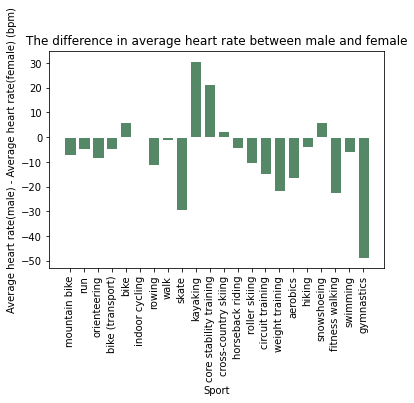

In [31]:
rddAInner = df2AInner.rdd
sportType = rddAInner.map(lambda row: row['sport']).collect()
diffAvg = rddAInner.map(lambda row: row['diffAvg']).collect()
xticks = plt.xticks(rotation=90)
xlabel = plt.xlabel('Sport')
ylabel = plt.ylabel('Average heart rate(male) - Average heart rate(female) (bpm)')
plot = plt.bar(sportType, diffAvg, facecolor='#558866', edgecolor='white')
title = plt.title('The difference in average heart rate between male and female')

This plot showed that in most of the sports having both genders participated, average heart rates of female are higher than male's.

##  Correlations of heart rate vs. speed, heart rate vs. altitude


We calculate the Pearson Correlation Coefficients between heart rate vs altitude, heart rate vs speed, the the average of those coefficients by sport and gender, then take the difference of average_coe(heart rate, altitude) and average_coe(heart rate, speed).we only look at workouts with non-empty speed values.

Visit the https://www.statisticshowto.com/probability-and-statistics/correlation-coefficient-formula/ to deep into more detail of Correlation concept

In [32]:
InteractiveShell.ast_node_interactivity = "all"
rdd2 = df.rdd
def covHeartRate(row):
    if row['heart_rate'] != '' and row['speed'] != '' and row['altitude'] != '':   
        if size(row['heart_rate']) == size(row['speed']) and size(row['heart_rate']) == size(row['altitude']):
            pearson_hr_al = stats.pearsonr(row['heart_rate'],row['altitude'])[0]
            pearson_hr_speed = stats.pearsonr(row['heart_rate'],row['speed'])[0] 
            abs_pearson_hr_al = abs(stats.pearsonr(row['heart_rate'],row['altitude'])[0])
            abs_pearson_hr_speed = abs(stats.pearsonr(row['heart_rate'],row['speed'])[0]) 
            return Row(id=int(row['id']), pearson_hr_al=float(pearson_hr_al)
                       , pearson_hr_speed=float(pearson_hr_speed), abs_pearson_hr_al=float(abs_pearson_hr_al)
                       , abs_pearson_hr_speed=float(abs_pearson_hr_speed)
                       , gender=str(row['gender']), sport=str(row['sport']),userId=row['userId'])
rddaHR2 = rdd2.filter(lambda row: row['speed'] is not None).map(covHeartRate)
df5 = spark.createDataFrame(rddaHR2).dropna()
print('\nSummary of coefficients table:')
df5.describe().toPandas()


Summary of coefficients table:


/home/louisedantas/.pyenv/versions/lewagon/lib/python3.8/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/louisedantas/.pyenv/versions/lewagon/lib/python3.8/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/louisedantas/.pyenv/versions/lewagon/lib/python3.8/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/louisedantas/.pyenv/versions/lewagon/lib/python3.8/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/lo

,summary,id,pearson_hr_al,pearson_hr_speed,abs_pearson_hr_al,abs_pearson_hr_speed,gender,sport,userId
0,count,31610,31610,31610,31610,31610,31610,31610,31610
1,mean,4.092393838097754E8,0.027007298727103706,0.18969346283737548,0.2741564031946918,0.34954295928056894,None,None,5246820.537899399
2,stddev,1.5316163929644313E8,0.3369084705220417,0.36964263912225903,0.1976679627513754,0.22458023766977972,None,None,4202855.639272751
3,min,9406163,-0.96993999956483,-0.8858991283273456,8.842876017139885E-6,3.734595825845982E-5,female,bike,2358
4,max,669263168,0.9427309603868331,0.9754014117310303,0.96993999956483,0.9754014117310303,unknown,walk,15326644


In [33]:
# Aggregate by gender & sport
df6 = df5.groupBy(['gender', 'sport']).agg({'abs_pearson_hr_al':'mean', 'abs_pearson_hr_speed':'mean'})
df6.createOrReplaceTempView("table3")
df6M = spark.sql("SELECT * FROM table3 WHERE gender = 'male'")
df6M = df6M.withColumnRenamed('avg(abs_pearson_hr_al)','mAvgPerHtAt') \
    .withColumnRenamed('avg(abs_pearson_hr_speed)','mAvgPerHtSp')

df6FM = spark.sql("SELECT * FROM table3 WHERE gender = 'female'")
df6FM = df6FM.withColumnRenamed('avg(abs_pearson_hr_al)','fmAvgPerHtAt') \
    .withColumnRenamed('avg(abs_pearson_hr_speed)','fmAvgPerHtSp')

In [34]:
rdd6MInner = df6M.rdd
rdd6FMInner = df6FM.rdd
sportTypeM = rdd6MInner.map(lambda row: row['sport']).collect()
sportTypeFM = rdd6FMInner.map(lambda row: row['sport']).collect()
perMhtat = rdd6MInner.map(lambda row: row['mAvgPerHtAt']).collect()
perMhtsp = rdd6MInner.map(lambda row: row['mAvgPerHtSp']).collect()
perFMhtat = rdd6FMInner.map(lambda row: row['fmAvgPerHtAt']).collect()
perFMhtsp = rdd6FMInner.map(lambda row: row['fmAvgPerHtSp']).collect()

meanMhtat, varMhtat = mean(perMhtat), var(perMhtat)
meanMhtsp, varMhtsp = mean(perMhtsp), var(perMhtsp)
meanFMhtat, varFMhtat = mean(perFMhtat), var(perFMhtat)
meanFMhtsp, varFMhtsp = mean(perFMhtsp), var(perFMhtsp)
column_list = [{'gender': 'male', 'correlation': '(heart rate, altitude)'
      , 'mean': float(meanMhtat), 'variance': float(varMhtat)}
     , {'gender': 'male','correlation': '(heart rate, speed)'
        ,'mean': float(meanMhtsp), 'variance': float(varMhtsp) }
     , {'gender': 'female', 'correlation':'(heart rate, altitude)'
      , 'mean': float(meanFMhtat), 'variance': float(varFMhtat)}
        , {'gender':'female', 'correlation':'(heart rate, speed)'
           , 'mean': float(meanFMhtsp), 'variance': float(varFMhtsp)}]
showdf6 = pd.DataFrame(column_list)
print("Average correlation coefficient of different sports for male and female:")
showdf6

/home/louisedantas/.pyenv/versions/lewagon/lib/python3.8/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/louisedantas/.pyenv/versions/lewagon/lib/python3.8/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/louisedantas/.pyenv/versions/lewagon/lib/python3.8/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/louisedantas/.pyenv/versions/lewagon/lib/python3.8/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/lo

Average correlation coefficient of different sports for male and female:


,gender,correlation,mean,variance
0,male,"(heart rate, altitude)",0.252790,0.005448
1,male,"(heart rate, speed)",0.355485,0.009398
2,female,"(heart rate, altitude)",0.242045,0.007578
3,female,"(heart rate, speed)",0.219460,0.005855


/tmp/ipykernel_3411/4031281743.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  xstick_labels0 = axs[0].set_xticklabels(sportTypeM, rotation=90)


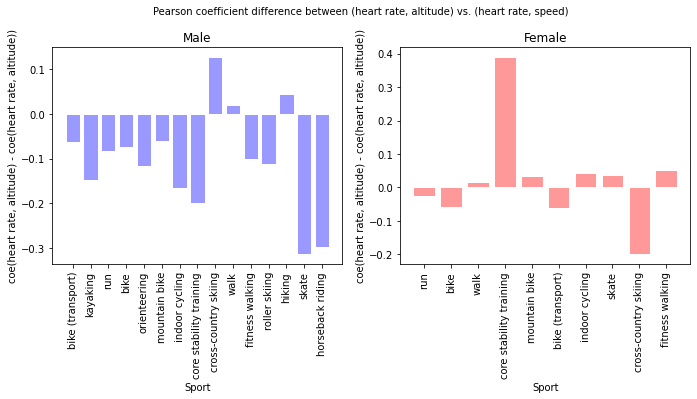

In [35]:
# Take the differences
diffMatsp = np.array(perMhtat) - np.array(perMhtsp)
diffFMatsp = np.array(perFMhtat) - np.array(perFMhtsp)

fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize=plt.figaspect(0.35))
xstick_labels0 = axs[0].set_xticklabels(sportTypeM, rotation=90)
xlabel0 = axs[0].set_xlabel('Sport')
ylabel0 = axs[0].set_ylabel(
    'coe(heart rate, altitude) - coe(heart rate, altitude))'
)
title0 = axs[0].set_title('Male')
plot0 = axs[0].bar(sportTypeM, diffMatsp, facecolor='#9999ff', edgecolor='white')
xstick1 = plt.xticks(rotation=90)
xlabel1 = axs[1].set_xlabel('Sport')
ylabel1 = axs[1].set_ylabel('coe(heart rate, altitude) - coe(heart rate, altitude))')
title1 = axs[1].set_title('Female')
plot1 = axs[1].bar(sportTypeFM, diffFMatsp, facecolor='#ff9999', edgecolor='white')
title = fig.text(
    0.5, 1.02, 'Pearson coefficient difference between (heart rate, altitude) vs. (heart rate, speed)'
    , ha='center', va='top', transform=fig.transFigure
)

The 2 charts shows that for both males and females, the average correlation between heart rate and altitude vs heart rate and speed are not so much different.

## Choice of sports in different periods of a day between male and female
We group the workouts into 4 groups base on started hour and try to see which kinds of sport people prefer at a specific time range of the day.

In [36]:
from datetime import *
from pyspark.sql.types import *
from pyspark.sql.functions import udf

# Apply filter to select workouts that have all records occuring in the sameday (cross out the ones that lasted
# more than one day).
rdd3=df.rdd
def same_day(row):
    if row['heart_rate'] != '' and row['speed'] != '' and row['altitude'] != '':   
        if size(row['heart_rate']) == size(row['speed']) and size(row['heart_rate']) == size(row['altitude']):
            dateValue = [datetime.fromtimestamp(t) - timedelta(hours=7) for t in row['timestamp']]
            return Row(
                id=int(row['id']), gender=row['gender'], timestamp=row['timestamp']
                , heartrate=row['heart_rate'], speed=row['speed'], altitude=row['altitude']
                , year=dateValue[0].year, month=dateValue[0].month, day=dateValue[0].day
                , yearl=dateValue[-1].year, monthl=dateValue[-1].month, dayl=dateValue[-1].day
                , sport=str(row['sport']), userId=row['userId']
            )
#  return Row(ratiohtsp=float(vecsp))
rddaHR3 = rdd3.filter(lambda row: row['speed'] is not None) \
    .map(same_day) \
    .filter(lambda row: row['year'] == row['yearl'] and row['month'] == row['monthl'] and row['day'] == row['dayl'])

df7 = spark.createDataFrame(rddaHR3).drop('year').drop('yearl').drop('month') \
    .drop('day').drop('monthl').drop('dayl')

# Group and workouts by 4 time ranges of the day based on workout start hour 
# (0: start hour from 0 - 5)
# (1: start hour from 6 - 11)
# (2: start hour from 12 - 17)
# (3: start hour from 18 - 24)
def markWorkout(row):
    hours = [(datetime.fromtimestamp(t) - timedelta(hours=7)).hour for t in row['timestamp']]
    mark = -1
    upIndex = -1
    if hours[0] >= 6 and hours[0] < 12:
        upIndex = [i for i in range(len(hours)) if hours[i] < 12][-1]
        mark = 1
    elif hours[0] >= 12 and hours[0] < 18:
        upIndex=[i for i in range(len(hours)) if hours[i] < 19][-1]
        mark = 2
    elif hours[0] >= 18 and hours[0] < 24:
        upIndex = [i for i in range(len(hours)) if hours[i] < 24][-1]
        mark = 3
    elif hours[0] >= 0 and hours[0] < 6:
        upIndex = [i for i in range(len(hours)) if hours[i] < 8][-1]
        mark = 0
    if mark !=- 1 and upIndex !=- 1:
        reTimestamp = row['timestamp'][:upIndex]
        dateValue = [datetime.fromtimestamp(t) for t in reTimestamp]
        reHeartRate = row['heartrate'][:upIndex]
        reAltitude = row['altitude'][:upIndex]
        reSpeed = row['speed'][:upIndex]
        count = upIndex + 1
        return Row(
            id=row['id'], gender=row['gender'], mark=mark, countTimestamp=count
            , reTimestamp=reTimestamp, dateValue=dateValue, reHeartRate=reHeartRate
            , reAltitude=reAltitude, reSpeed=reSpeed, sport=str(row['sport']), userId=row['userId']
        )
    
rdd31 = df7.rdd.map(markWorkout).filter(lambda row: row['countTimestamp']>10)
df8 = spark.createDataFrame(rdd31)
DataFrame(df8.dtypes, columns=['Column Name','Data type'])
df8.describe().toPandas()
df8.limit(3).toPandas()

,Column Name,Data type
0,id,bigint
1,gender,string
2,mark,bigint
3,countTimestamp,bigint
4,reTimestamp,array<bigint>
5,dateValue,array<timestamp>
6,reHeartRate,array<bigint>
7,reAltitude,array<double>
8,reSpeed,array<double>
9,sport,string


,summary,id,gender,mark,countTimestamp,sport,userId
0,count,30831,30831,30831,30831,30831,30831
1,mean,4.094921911705102E8,None,1.624566183386851,468.2385585936233,None,5201891.682008368
2,stddev,1.529933788427888E8,None,0.9506020690241086,91.9237708280875,None,4202117.301510791
3,min,9406163,female,0,11,bike,2358
4,max,669263168,unknown,3,500,walk,15326644


Traceback (most recent call last):
  File "/home/louisedantas/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/pyspark/python/lib/pyspark.zip/pyspark/daemon.py", line 186, in manager
  File "/home/louisedantas/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/pyspark/python/lib/pyspark.zip/pyspark/daemon.py", line 74, in worker
  File "/home/louisedantas/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/pyspark/python/lib/pyspark.zip/pyspark/worker.py", line 663, in main
    if read_int(infile) == SpecialLengths.END_OF_STREAM:
  File "/home/louisedantas/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/pyspark/python/lib/pyspark.zip/pyspark/serializers.py", line 564, in read_int
    raise EOFError
EOFError


,id,gender,mark,countTimestamp,reTimestamp,dateValue,reHeartRate,reAltitude,reSpeed,sport,userId
0,396826535,male,1,51,"[1408898746, 1408898754, 1408898765, 140889877...","[2014-08-24 18:45:46, 2014-08-24 18:45:54, 201...","[100, 111, 120, 119, 120, 116, 125, 128, 131, ...","[41.6, 40.6, 40.6, 38.4, 37.0, 34.0, 34.0, 34....","[6.8652, 16.4736, 19.1988, 20.4804, 31.3956, 3...",bike,10921915
1,392337038,male,2,500,"[1408221682, 1408221687, 1408221699, 140822170...","[2014-08-16 22:41:22, 2014-08-16 22:41:27, 201...","[100, 105, 111, 110, 108, 115, 126, 130, 132, ...","[38.4, 39.0, 39.0, 38.2, 36.8, 36.8, 36.8, 35....","[9.0792, 13.284, 15.9336, 10.9476, 16.1676, 30...",bike,10921915
2,389643739,male,1,304,"[1407858459, 1407858466, 1407858478, 140785849...","[2014-08-12 17:47:39, 2014-08-12 17:47:46, 201...","[99, 105, 113, 110, 109, 110, 108, 121, 116, 1...","[76.4, 73.2, 72.4, 73.0, 73.0, 70.8, 69.2, 69....","[4.0464, 13.8204, 16.9776, 19.9404, 28.7856, 3...",bike,10921915


In [37]:
df8Count = df8.groupBy(['mark','sport','gender']).count().orderBy(['mark','sport','gender'])
rdd8Count = df8Count.rdd
df8Count.createOrReplaceTempView("table4")
df8CountM = spark.sql("SELECT * from table4 where gender='male'")
#df8CountM.toPandas()
df8CountFM = spark.sql("SELECT * from table4 where gender='female'")
#df8CountFM.toPandas()

sportTypeM0 = rdd8Count.filter(
    lambda row: row['mark'] == 0 and row['gender'] == 'male'
).map(lambda row: row['sport']).collect()
sportTypeFM0 = rdd8Count.filter(
    lambda row: row['mark'] == 0 and row['gender'] == 'female'
).map(lambda row: row['sport']).collect()
countM0 = rdd8Count.filter(
    lambda row: row['mark'] == 0 and row['gender'] == 'male'
).map(lambda row: row['count']).collect()
countFM0 = rdd8Count.filter(
    lambda row: row['mark'] == 0 and row['gender'] == 'female'
).map(lambda row: row['count']).collect()

sportTypeM1 = rdd8Count.filter(
    lambda row: row['mark'] == 1 and row['gender'] == 'male'
).map(lambda row: row['sport']).collect()
sportTypeFM1 = rdd8Count.filter(
    lambda row: row['mark'] == 1 and row['gender'] == 'female'
).map(lambda row: row['sport']).collect()
countM1 = rdd8Count.filter(
    lambda row: row['mark'] == 1 and row['gender'] == 'male'
).map(lambda row: row['count']).collect()
countFM1 = rdd8Count.filter(
    lambda row: row['mark'] == 1 and row['gender'] == 'female'
).map(lambda row: row['count']).collect()

sportTypeM2 = rdd8Count.filter(
    lambda row: row['mark'] == 2 and row['gender'] == 'male'
).map(lambda row: row['sport']).collect()
sportTypeFM2 = rdd8Count.filter(
    lambda row: row['mark'] == 2 and row['gender'] == 'female'
).map(lambda row: row['sport']).collect()

countM2 = rdd8Count.filter(
    lambda row: row['mark'] == 2 and row['gender'] == 'male'

).map(lambda row: row['count']).collect()
countFM2 = rdd8Count.filter(
    lambda row: row['mark'] == 2 and row['gender'] == 'female'
).map(lambda row: row['count']).collect()

sportTypeM3 = rdd8Count.filter(
    lambda row: row['mark'] == 3 and row['gender'] == 'male'
).map(lambda row: row['sport']).collect()
sportTypeFM3 = rdd8Count.filter(
    lambda row: row['mark'] == 3 and row['gender'] == 'female'
).map(lambda row: row['sport']).collect()
countM3 = rdd8Count.filter(
    lambda row: row['mark'] == 3 and row['gender'] == 'male'
).map(lambda row: row['count']).collect()
countFM3 = rdd8Count.filter(
    lambda row: row['mark'] == 3 and row['gender'] == 'female'
).map(lambda row: row['count']).collect()

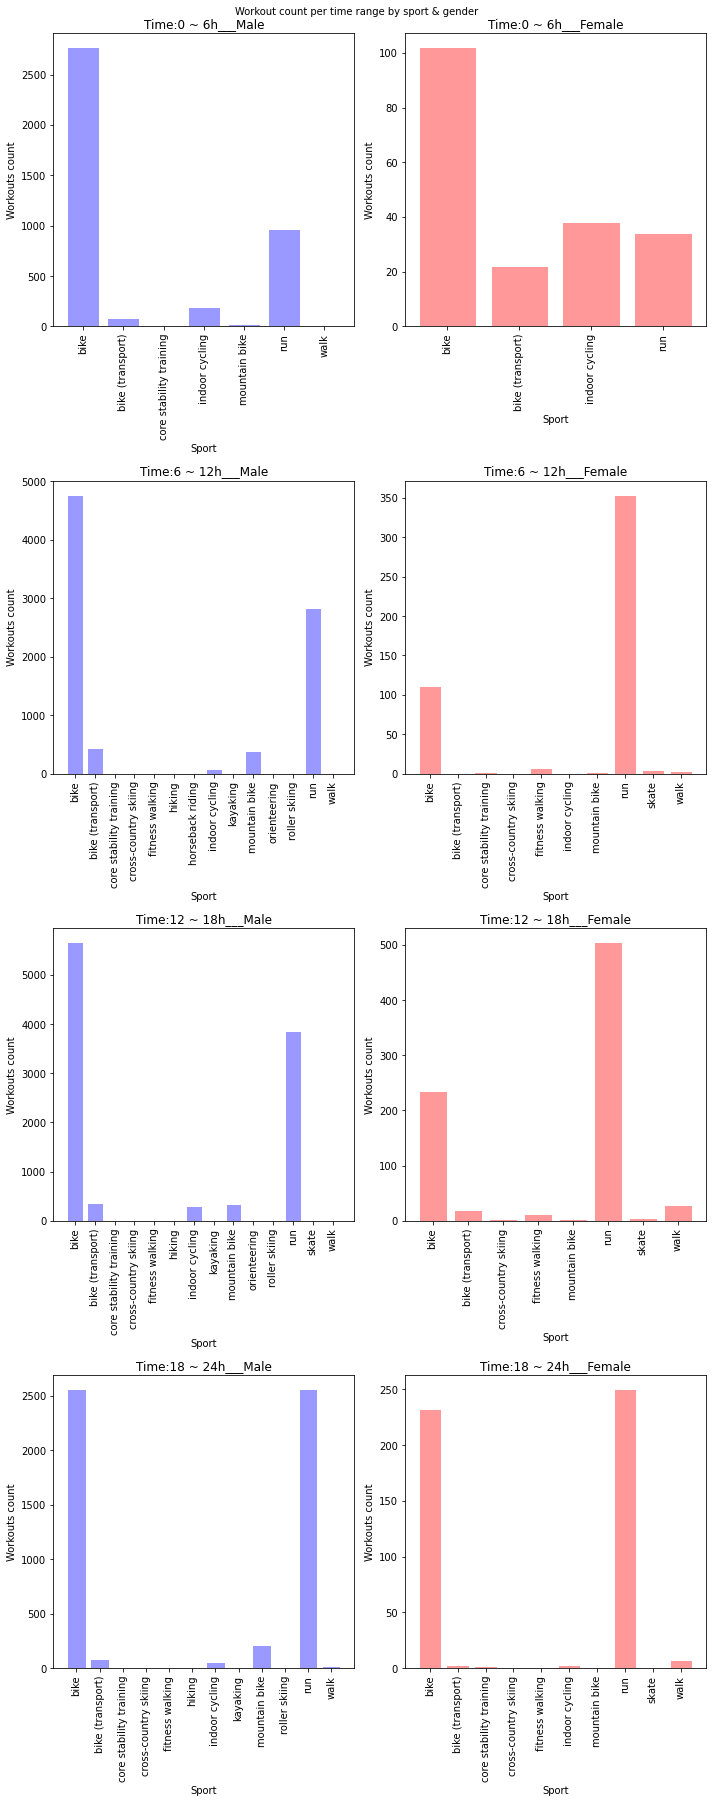

In [38]:
fig,axes = plt.subplots(4,2,figsize=(10,25))
subplot_adj = plt.subplots_adjust(wspace=0.3, hspace=0.7)

for i in range(8):
    ax = plt.subplot(4, 2, i+1)
    sca_x = plt.sca(ax)
    xticks = plt.xticks(rotation=90)
    xlabel = plt.xlabel('Sport')
    ylabel = plt.ylabel('Workouts count')
    if i%2 == 0:
        title = plt.title('Time:' + str(int(i / 2 * 6)) + ' ~ ' + str(int(i / 2 * 6) + 6) + 'h___Male')
        sportType = locals()['sportTypeM' + str(int(i / 2))]
        count = locals()['countM' + str(int(i/2))]
        facecolor = '#9999ff'
        plot = bar(sportType, count, facecolor=facecolor, edgecolor='white')
    else:
        title = plt.title(
            'Time:' + str(int((i - 1) / 2 * 6)) + ' ~ ' + str(int((i - 1) / 2 * 6)+ 6) + 'h___Female'
        )
        sportType = locals()['sportTypeFM'+str(int(i/2))]
        count = locals()['countFM'+str(int(i/2))]
        facecolor = '#ff9999'
        plot = bar(sportType, count, facecolor=facecolor, edgecolor='white')
a = fig.tight_layout()
chart_title =fig.text(0.5, 1, 'Workout count per time range by sport & gender', 
            ha='center', va='top', fontsize='medium', transform=fig.transFigure)

From the plots, it can be seen that bike and run are the dominant activities in term of participation, regardless of time of the day and gender. Another observation is that based on the scale of the y-axes, males exercised much more than female in all period of times.

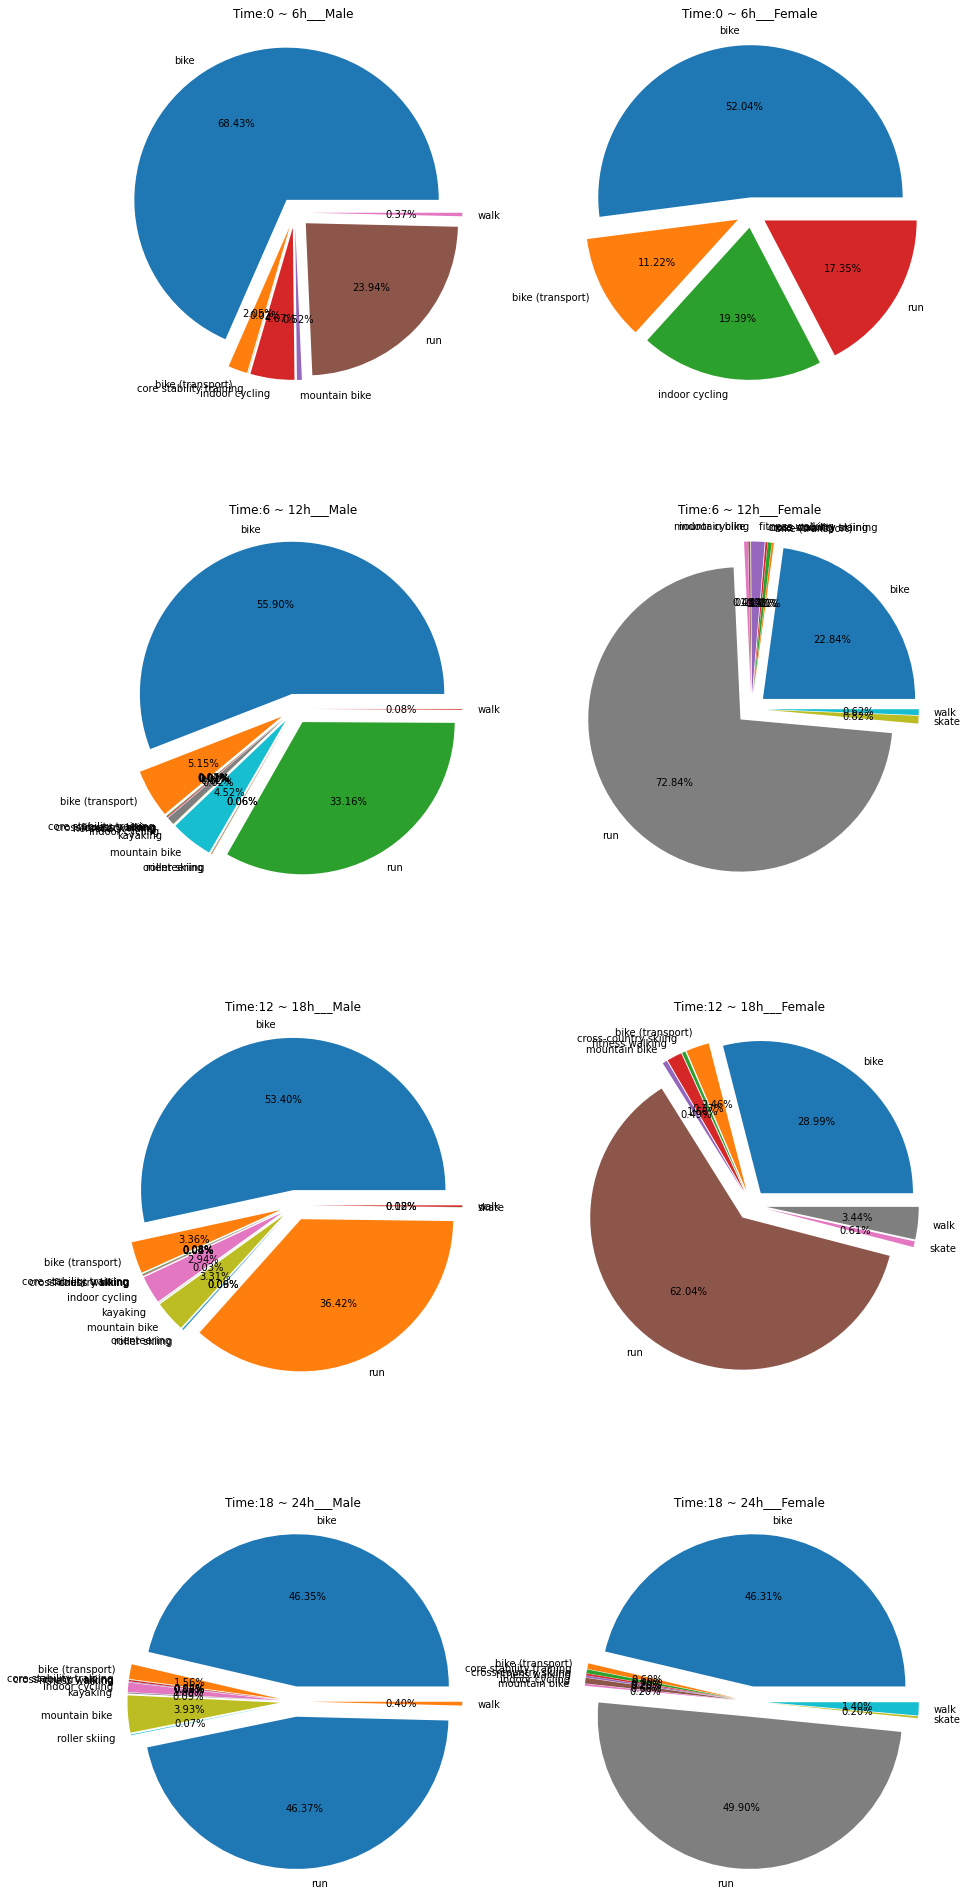

In [39]:
fig,axes = plt.subplots(4,2, figsize=(15, 35))


for i in range(8):
    ax = plt.subplot(4, 2 , i + 1)
    plt.sca(ax)
    if i%2 == 0:
        subplot_title = plt.title('Time:' + str(int(i/2*6)) + ' ~ ' + str(int(i/2 * 6) + 6) + 'h___Male ')
        sportType = locals()['sportTypeM' + str(int(i/2))]
        count = locals()['countM' + str(int(i/2))]
        explode = tuple([0.1 for i in range(len(sportType))])
        
        facecolor = '#9999ff'
        plot = plt.pie(x=count, autopct='%.2f%%'#, shadow=True
                       , labels=sportType, explode=explode)
    else:
        subplot_title = plt.title('Time:' + str(int((i-1)/2*6)) + ' ~ ' + str(int((i-1)/2*6) + 6) +'h___Female ')
        sportType = locals()['sportTypeFM' + str(int(i/2))]
        count = locals()['countFM'+str(int(i/2))]
        explode = tuple([0.1 for i in range(len(sportType))])
        
        facecolor = '#ff9999'
        plot = plt.pie(x=count, labels=sportType#, shadow=True
                       , autopct='%.2f%%', explode=explode)

As we can see once again, the percentage in the pie charts show the dorminance of bike and run compared to other sport. This analysis is quite similar to one in the Exploratory Notebook, just in a different view angle

## Average heartrate, altitude, speed change for each sport during different periods of the day## 

In [40]:
InteractiveShell.ast_node_interactivity = "all"
rdd8 = df8.rdd
def avgReHeartRate(row):
    if row['reHeartRate'] != '':
        reAvgHeartRate = np.mean(row['reHeartRate'])
        reVarHeartRate = np.var(row['reHeartRate'])
        reAvgAltitude = np.mean(row['reAltitude'])
        reVarAltitude = np.var(row['reAltitude'])
        reAvgSpeed = np.mean(row['reSpeed'])
        reVarSpeed = np.var(row['reSpeed'])
        return Row(
            id = int(row['id'])
            , mark = row['mark']
            , gender = str(row['gender'])
            , sport = str(row['sport'])
            , userId = int(row['userId'])
            , reAvgHeartRate = float(reAvgHeartRate)
            , reVarHeartRate = float(reVarHeartRate)
            , reAvgAltitude = float(reAvgAltitude)
            , reVarAltitude = float(reVarAltitude)
            , reAvgSpeed = float(reAvgSpeed)
            , reVarSpeed = float(reVarSpeed)
        )
   
rdda8HR = rdd8.map(avgReHeartRate)

df9 = spark.createDataFrame(rdda8HR)
DataFrame(df9.dtypes, columns = ['Column Name','Data type'])


df9AvgHearRate=df9.groupBy(['mark','sport','gender']) \
    .avg(
        'reAvgHeartRate', 'reVarHeartRate'
        , 'reAvgAltitude', 'reVarAltitude'
        , 'reAvgSpeed', 'reVarSpeed'
    ).orderBy(['mark','sport','gender'])

df9AvgHearRate.limit(5).toPandas()

,Column Name,Data type
0,id,bigint
1,mark,bigint
2,gender,string
3,sport,string
4,userId,bigint
5,reAvgHeartRate,double
6,reVarHeartRate,double
7,reAvgAltitude,double
8,reVarAltitude,double
9,reAvgSpeed,double


,mark,sport,gender,avg(reAvgHeartRate),avg(reVarHeartRate),avg(reAvgAltitude),avg(reVarAltitude),avg(reAvgSpeed),avg(reVarSpeed)
0,0,bike,female,132.787123,313.752553,115.620905,126.714761,24.194663,39.747579
1,0,bike,male,133.346470,199.838022,91.384496,3398.672781,27.005974,47.032507
2,0,bike,unknown,152.455912,189.831612,38.807782,254.083111,30.559216,58.780465
3,0,bike (transport),female,139.012206,236.944806,40.756349,344.974288,22.029448,50.755164
4,0,bike (transport),male,130.472120,173.048766,77.846707,270.625571,23.174366,42.058746


In [41]:
rdd9AvgHearRate = df9AvgHearRate.rdd
rddtimeM0 = rdd9AvgHearRate.filter(lambda row: row['mark'] == 0 and row['gender'] == 'male')
rddtimeM1 = rdd9AvgHearRate.filter(lambda row: row['mark'] == 1 and row['gender'] == 'male')
rddtimeM2 = rdd9AvgHearRate.filter(lambda row: row['mark'] == 2 and row['gender'] == 'male')
rddtimeM3 = rdd9AvgHearRate.filter(lambda row: row['mark'] == 3 and row['gender'] == 'male')
rddtimeFM0 = rdd9AvgHearRate.filter(lambda row: row['mark'] == 0 and row['gender'] == 'female')
rddtimeFM1 = rdd9AvgHearRate.filter(lambda row: row['mark'] == 1 and row['gender'] == 'female')
rddtimeFM2 = rdd9AvgHearRate.filter(lambda row: row['mark'] == 2 and row['gender'] == 'female')
rddtimeFM3 = rdd9AvgHearRate.filter(lambda row: row['mark'] == 3 and row['gender'] == 'female')

dftimeM0 = spark.createDataFrame(rddtimeM0) \
    .withColumnRenamed('avg(reAvgHeartRate)', 'MreAvgSptAvgHeartRate0') \
    .withColumnRenamed('avg(reVarHeartRate)', 'MreAvgSptVarHeartRate0') \
    .withColumnRenamed('avg(reAvgAltitude)', 'MreAvgSptAvgAltitude0') \
    .withColumnRenamed('avg(reVarAltitude)', 'MreAvgSptVarAltitude0') \
    .withColumnRenamed('avg(reAvgSpeed)', 'MreAvgSptAvgSpeed0') \
    .withColumnRenamed('avg(reVarSpeed)', 'MreAvgSptVarSpeed0')
    
dftimeM1 = spark.createDataFrame(rddtimeM1) \
    .withColumnRenamed('avg(reAvgHeartRate)', 'MreAvgSptAvgHeartRate1') \
    .withColumnRenamed('avg(reVarHeartRate)', 'MreAvgSptVarHeartRate1') \
    .withColumnRenamed('avg(reAvgAltitude)', 'MreAvgSptAvgAltitude1') \
    .withColumnRenamed('avg(reVarAltitude)', 'MreAvgSptVarAltitude1') \
    .withColumnRenamed('avg(reAvgSpeed)', 'MreAvgSptAvgSpeed1') \
    .withColumnRenamed('avg(reVarSpeed)', 'MreAvgSptVarSpeed1')

dftimeM2 = spark.createDataFrame(rddtimeM2) \
    .withColumnRenamed('avg(reAvgHeartRate)', 'MreAvgSptAvgHeartRate2') \
    .withColumnRenamed('avg(reVarHeartRate)', 'MreAvgSptVarHeartRate2') \
    .withColumnRenamed('avg(reAvgAltitude)', 'MreAvgSptAvgAltitude2') \
    .withColumnRenamed('avg(reVarAltitude)', 'MreAvgSptVarAltitude2') \
    .withColumnRenamed('avg(reAvgSpeed)', 'MreAvgSptAvgSpeed2') \
    .withColumnRenamed('avg(reVarSpeed)', 'MreAvgSptVarSpeed2')

dftimeM3 = spark.createDataFrame(rddtimeM3) \
    .withColumnRenamed('avg(reAvgHeartRate)', 'MreAvgSptAvgHeartRate3') \
    .withColumnRenamed('avg(reVarHeartRate)', 'MreAvgSptVarHeartRate3') \
    .withColumnRenamed('avg(reAvgAltitude)', 'MreAvgSptAvgAltitude3') \
    .withColumnRenamed('avg(reVarAltitude)', 'MreAvgSptVarAltitude3') \
    .withColumnRenamed('avg(reAvgSpeed)', 'MreAvgSptAvgSpeed3') \
    .withColumnRenamed('avg(reVarSpeed)', 'MreAvgSptVarSpeed3')

dftimeFM0 = spark.createDataFrame(rddtimeFM0) \
    .withColumnRenamed('avg(reAvgHeartRate)', 'FMreAvgSptAvgHeartRate0') \
    .withColumnRenamed('avg(reVarHeartRate)', 'FMreAvgSptVarHeartRate0') \
    .withColumnRenamed('avg(reAvgAltitude)', 'FMreAvgSptAvgAltitude0') \
    .withColumnRenamed('avg(reVarAltitude)', 'FMreAvgSptVarAltitude0') \
    .withColumnRenamed('avg(reAvgSpeed)', 'FMreAvgSptAvgSpeed0') \
    .withColumnRenamed('avg(reVarSpeed)','FMreAvgSptVarSpeed0')

dftimeFM1 = spark.createDataFrame(rddtimeFM1) \
    .withColumnRenamed('avg(reAvgHeartRate)', 'FMreAvgSptAvgHeartRate1') \
    .withColumnRenamed('avg(reVarHeartRate)', 'FMreAvgSptVarHeartRate1') \
    .withColumnRenamed('avg(reAvgAltitude)', 'FMreAvgSptAvgAltitude1') \
    .withColumnRenamed('avg(reVarAltitude)', 'FMreAvgSptVarAltitude1') \
    .withColumnRenamed('avg(reAvgSpeed)', 'FMreAvgSptAvgSpeed1') \
    .withColumnRenamed('avg(reVarSpeed)', 'FMreAvgSptVarSpeed1')

dftimeFM2 = spark.createDataFrame(rddtimeFM2) \
    .withColumnRenamed('avg(reAvgHeartRate)', 'FMreAvgSptAvgHeartRate2') \
    .withColumnRenamed('avg(reVarHeartRate)', 'FMreAvgSptVarHeartRate2') \
    .withColumnRenamed('avg(reAvgAltitude)', 'FMreAvgSptAvgAltitude2') \
    .withColumnRenamed('avg(reVarAltitude)', 'FMreAvgSptVarAltitude2') \
    .withColumnRenamed('avg(reAvgSpeed)', 'FMreAvgSptAvgSpeed2') \
    .withColumnRenamed('avg(reVarSpeed)', 'FMreAvgSptVarSpeed2')

dftimeFM3 = spark.createDataFrame(rddtimeFM3) \
    .withColumnRenamed('avg(reAvgHeartRate)', 'FMreAvgSptAvgHeartRate3') \
    .withColumnRenamed('avg(reVarHeartRate)', 'FMreAvgSptVarHeartRate3') \
    .withColumnRenamed('avg(reAvgAltitude)', 'FMreAvgSptAvgAltitude3') \
    .withColumnRenamed('avg(reVarAltitude)', 'FMreAvgSptVarAltitude3') \
    .withColumnRenamed('avg(reAvgSpeed)', 'FMreAvgSptAvgSpeed3') \
    .withColumnRenamed('avg(reVarSpeed)', 'FMreAvgSptVarSpeed3')

dftimeMAll = dftimeM0.join(dftimeM1, 'sport', 'outer') \
    .join(dftimeM2, 'sport', 'outer') \
    .join(dftimeM3, 'sport', 'outer')
dftimeMAll.limit(3).toPandas()
dftimeFMAll = dftimeFM0.join(dftimeFM1, 'sport', 'outer') \
    .join(dftimeFM2, 'sport', 'outer').join(dftimeFM3, 'sport', 'outer')
dftimeFMAll.limit(3).toPandas()

22/04/22 15:37:15 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


,sport,mark,gender,MreAvgSptAvgHeartRate0,MreAvgSptVarHeartRate0,MreAvgSptAvgAltitude0,MreAvgSptVarAltitude0,MreAvgSptAvgSpeed0,MreAvgSptVarSpeed0,mark,...,MreAvgSptAvgSpeed2,MreAvgSptVarSpeed2,mark,gender,MreAvgSptAvgHeartRate3,MreAvgSptVarHeartRate3,MreAvgSptAvgAltitude3,MreAvgSptVarAltitude3,MreAvgSptAvgSpeed3,MreAvgSptVarSpeed3
0,bike,0,male,133.346470,199.838022,91.384496,3398.672781,27.005974,47.032507,1,...,27.143723,57.793399,3,male,135.715601,195.813847,120.392071,644.349052,27.277948,54.060059
1,bike (transport),0,male,130.472120,173.048766,77.846707,270.625571,23.174366,42.058746,1,...,24.052929,39.372562,3,male,133.455492,154.102438,74.155161,180.942632,23.895282,35.541721
2,core stability training,0,male,160.286573,142.304649,538.031663,6.040921,12.259840,3.622825,1,...,22.900496,166.988892,3,male,138.374749,379.059964,310.957916,8.088409,7.554589,27.777835


,sport,mark,gender,FMreAvgSptAvgHeartRate0,FMreAvgSptVarHeartRate0,FMreAvgSptAvgAltitude0,FMreAvgSptVarAltitude0,FMreAvgSptAvgSpeed0,FMreAvgSptVarSpeed0,mark,...,FMreAvgSptAvgSpeed2,FMreAvgSptVarSpeed2,mark,gender,FMreAvgSptAvgHeartRate3,FMreAvgSptVarHeartRate3,FMreAvgSptAvgAltitude3,FMreAvgSptVarAltitude3,FMreAvgSptAvgSpeed3,FMreAvgSptVarSpeed3
0,bike,0.0,female,132.787123,313.752553,115.620905,126.714761,24.194663,39.747579,1,...,24.371722,40.547825,3,female,134.356325,207.139711,59.413708,311.289679,24.545340,41.132972
1,bike (transport),0.0,female,139.012206,236.944806,40.756349,344.974288,22.029448,50.755164,1,...,20.160141,26.611461,3,female,151.528390,133.015562,30.091249,206.019568,21.428111,50.327342
2,core stability training,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,1,...,NaN,NaN,3,female,87.863727,77.479343,56.451102,16.782281,5.885928,0.423538


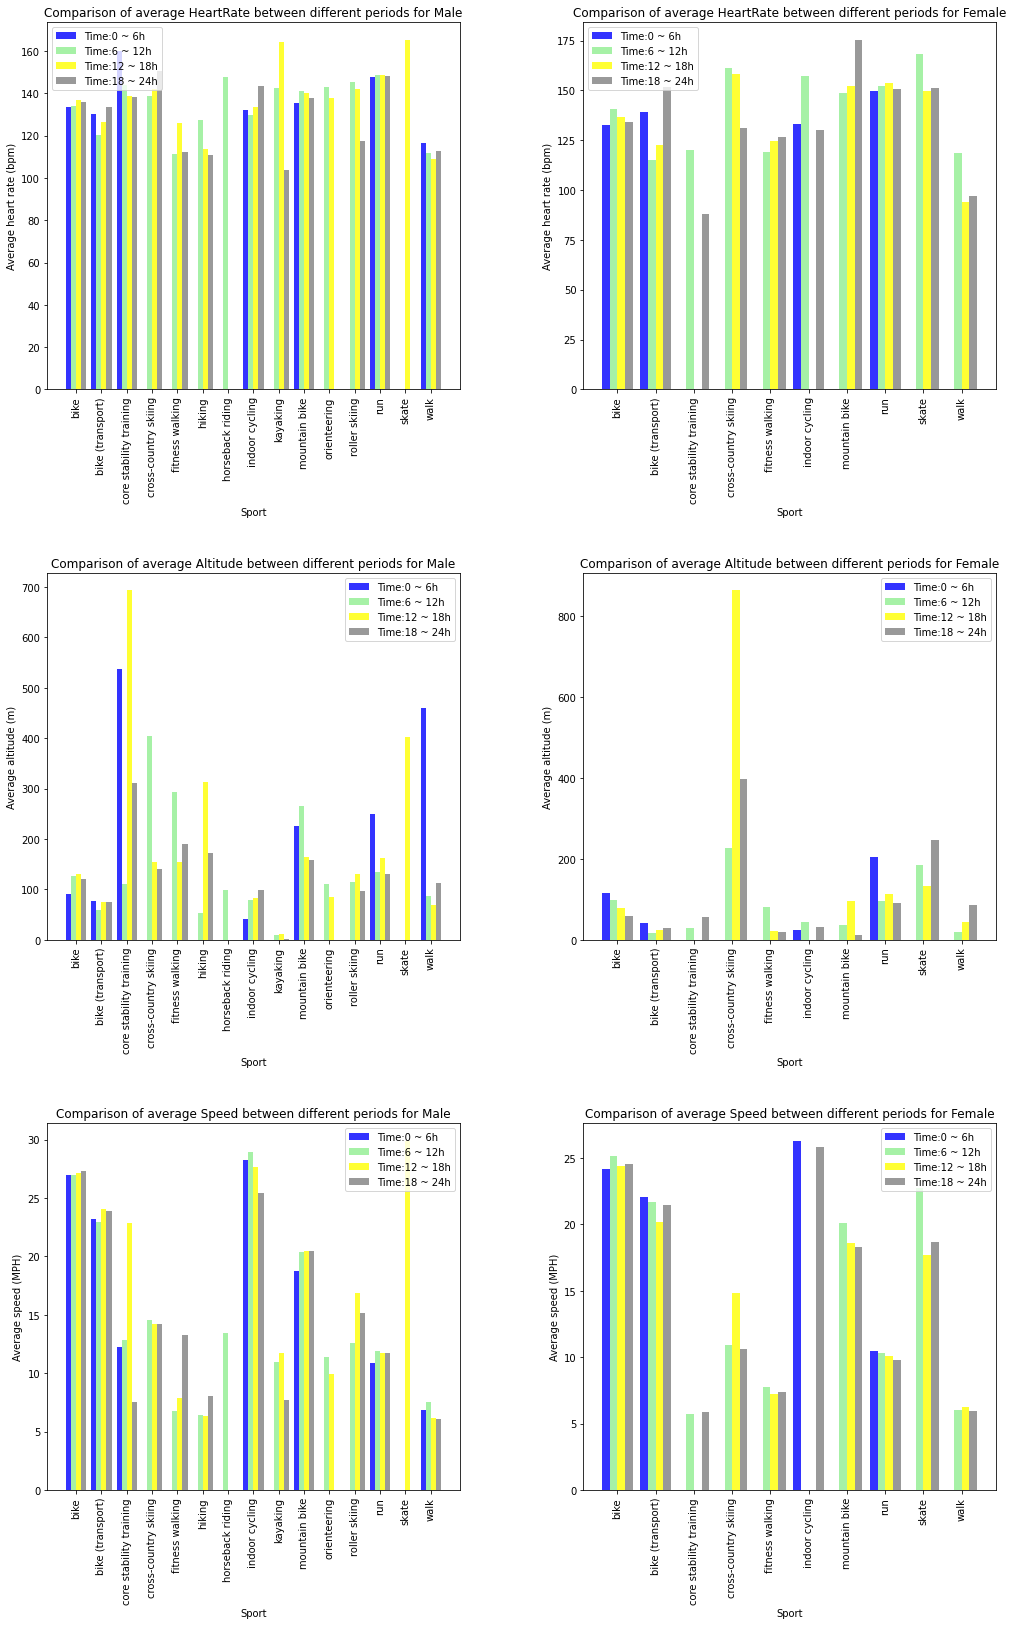

In [42]:
fig, axes = plt.subplots(3, 2, figsize=(17, 27))
plot = plt.subplots_adjust(wspace=0.3, hspace=0.5)

bar_width = 0.2
colors = ['blue', 'lightgreen', 'yellow', 'grey']
        
for j in range(6):
    ax = plt.subplot(3, 2, j+1)
    plt.sca(ax)
    if int(j/2) == 1:
        nameStr1 = 'reAvgSptAvgAltitude'
        nameStr3 = 'Altitude'
        nameStr5 = 'altitude (m)'

    elif int(j/2) == 2:
        nameStr1 = 'reAvgSptAvgSpeed'
        nameStr3 = 'Speed'
        nameStr5 = 'speed (MPH)'

    elif int(j/2) == 0:
        nameStr1 = 'reAvgSptAvgHeartRate'
        nameStr3 = 'HeartRate'
        nameStr5 = 'heart rate (bpm)'        
    if j % 2 == 0:
        nameStr2 = 'M'
        nameStr4 = 'Male'
    else:
        nameStr2 = 'FM'
        nameStr4 = 'Female'
    dftimeAll = locals()['dftime' + nameStr2 + 'All']
    dftimeAllSportType = dftimeAll.rdd.map(lambda row: row['sport']).collect() 
    for k in range(4):
        rowName = nameStr2 + nameStr1 + str(k)
        dfTimeLi = dftimeAll.rdd.map(lambda row: row[rowName]).collect()
        dfTimeLi = [0 if i == None else i for i in dfTimeLi]
        plot = plt.bar(x=np.arange(len(dftimeAllSportType)) + k * bar_width
                , height=dfTimeLi, label='Time:' + str(int(k*6)) + ' ~ ' + str(int(k*6)+6) + 'h'
                , color=colors[k], alpha=0.8, width=bar_width)
    xsticks = plt.xticks(np.arange(len(dftimeAllSportType)) + 1.5 * bar_width
                         , dftimeAllSportType, rotation=90)
    title = plt.title("Comparison of average " + nameStr3 + " between different periods for " + nameStr4)
    legend = plt.legend()
    xlabel = plt.xlabel("Sport")
    ylabel = plt.ylabel("Average " + nameStr5)

For average heart rate, there is no much difference within a sport among different time periods of a day, but the overall difference bewtween sports can be observed.
Next, find the overall average measurements per time period across all sports:

In [43]:
InteractiveShell.ast_node_interactivity = "all"
dftimeMIN = dftimeM0.join(dftimeM1, 'sport', 'inner') \
    .join(dftimeM2, 'sport', 'inner') \
    .join(dftimeM3, 'sport', 'inner')
dftimeMIN.toPandas()
dftimeFMIN = dftimeFM0.join(dftimeFM1, 'sport', 'inner') \
    .join(dftimeFM2, 'sport', 'inner') \
    .join(dftimeFM3, 'sport', 'inner')
dftimeFMIN.limit(5).toPandas()

,sport,mark,gender,MreAvgSptAvgHeartRate0,MreAvgSptVarHeartRate0,MreAvgSptAvgAltitude0,MreAvgSptVarAltitude0,MreAvgSptAvgSpeed0,MreAvgSptVarSpeed0,mark,...,MreAvgSptAvgSpeed2,MreAvgSptVarSpeed2,mark,gender,MreAvgSptAvgHeartRate3,MreAvgSptVarHeartRate3,MreAvgSptAvgAltitude3,MreAvgSptVarAltitude3,MreAvgSptAvgSpeed3,MreAvgSptVarSpeed3
0,bike,0,male,133.346470,199.838022,91.384496,3398.672781,27.005974,47.032507,1,...,27.143723,57.793399,3,male,135.715601,195.813847,120.392071,644.349052,27.277948,54.060059
1,bike (transport),0,male,130.472120,173.048766,77.846707,270.625571,23.174366,42.058746,1,...,24.052929,39.372562,3,male,133.455492,154.102438,74.155161,180.942632,23.895282,35.541721
2,core stability training,0,male,160.286573,142.304649,538.031663,6.040921,12.259840,3.622825,1,...,22.900496,166.988892,3,male,138.374749,379.059964,310.957916,8.088409,7.554589,27.777835
3,indoor cycling,0,male,132.293368,169.844651,41.404552,320.625749,28.235294,18.442028,1,...,27.634052,35.354988,3,male,143.519330,278.485206,99.591656,92.241860,25.447818,66.075884
4,mountain bike,0,male,135.304582,234.377225,226.462202,3021.039251,18.748969,48.348562,1,...,20.512045,61.011194,3,male,137.661147,242.834758,157.724175,1578.649837,20.433433,55.333610
5,run,0,male,147.973868,130.948324,248.899996,278.275903,10.882289,2.876694,1,...,11.716326,3.031185,3,male,148.036515,137.474432,131.026297,293.942126,11.756812,3.334154
6,walk,0,male,116.773681,120.008351,460.549579,172.063105,6.899477,0.901705,1,...,6.168765,1.391065,3,male,112.702405,45.707449,112.750774,60.343429,6.125734,0.695760


,sport,mark,gender,FMreAvgSptAvgHeartRate0,FMreAvgSptVarHeartRate0,FMreAvgSptAvgAltitude0,FMreAvgSptVarAltitude0,FMreAvgSptAvgSpeed0,FMreAvgSptVarSpeed0,mark,...,FMreAvgSptAvgSpeed2,FMreAvgSptVarSpeed2,mark,gender,FMreAvgSptAvgHeartRate3,FMreAvgSptVarHeartRate3,FMreAvgSptAvgAltitude3,FMreAvgSptVarAltitude3,FMreAvgSptAvgSpeed3,FMreAvgSptVarSpeed3
0,bike,0,female,132.787123,313.752553,115.620905,126.714761,24.194663,39.747579,1,...,24.371722,40.547825,3,female,134.356325,207.139711,59.413708,311.289679,24.545340,41.132972
1,bike (transport),0,female,139.012206,236.944806,40.756349,344.974288,22.029448,50.755164,1,...,20.160141,26.611461,3,female,151.528390,133.015562,30.091249,206.019568,21.428111,50.327342
2,run,0,female,149.833785,148.619743,205.496511,264.930567,10.480284,3.455016,1,...,10.065654,2.648728,3,female,150.623535,129.881281,89.973594,180.239852,9.791191,3.210949


In [44]:
MaverageHeartRate = []
MaverageAltitude = []
MaverageSpeed = []
for i in range(4):
    MaverageHeartRate.append(
        mean(dftimeMIN.rdd.map(
            lambda row: row['MreAvgSptAvgHeartRate' + str(i)]).collect()
            )
    )
    
    MaverageAltitude.append(
        mean(dftimeMIN.rdd.map(
            lambda row: row['MreAvgSptAvgAltitude' + str(i)]).collect()
            )
    )
    MaverageSpeed.append(
        mean(dftimeMIN.rdd.map(
            lambda row: row['MreAvgSptAvgSpeed' + str(i)]).collect()))
    
FMaverageHeartRate = []
FMaverageAltitude = []
FMaverageSpeed = []
for i in range(4):
    FMaverageHeartRate.append(
        mean(dftimeFMIN.rdd.map(
            lambda row: row['FMreAvgSptAvgHeartRate' + str(i)]).collect()
            )
    )
    
    FMaverageAltitude.append(
        mean(dftimeFMIN.rdd.map(
            lambda row: row['FMreAvgSptAvgAltitude' + str(i)]).collect()
            )
    )
    FMaverageSpeed.append(mean(dftimeFMIN.rdd.map(lambda row: row['FMreAvgSptAvgSpeed' + str(i)]).collect()))

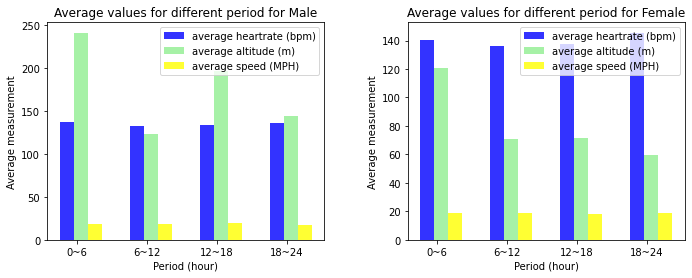

In [45]:
fig,axes = plt.subplots(2, 1,figsize=plt.figaspect(0.35))
subplot_adj = plt.subplots_adjust(wspace =0.3, hspace =0.5)

bar_width = 0.2
colors = ['blue', 'lightgreen', 'yellow']
timesP = ['0~6', '6~12', '12~18', '18~24']

for j in range(2):
    ax = plt.subplot(1, 2, j + 1)
    plotsca = plt.sca(ax)       
    if j % 2 == 0:
        nameStr2 = 'M'
        nameStr4 = 'Male'
    else:
        nameStr2 = 'FM'
        nameStr4 = 'Female'    
    for k in range(3):
        if k == 0:
            nameStr6 = 'averageHeartRate'
            nameStr7 = 'average heartrate (bpm)'
        elif k == 1:
            nameStr6 = 'averageAltitude'
            nameStr7 = 'average altitude (m)'
        elif k == 2:
            nameStr6 = 'averageSpeed'
            nameStr7 = 'average speed (MPH)'
        showY = locals()[nameStr2 + nameStr6]
        plot = plt.bar(
            x=np.arange(len(timesP)) + k * bar_width
            , height=showY, label=nameStr7, color=colors[k]
            , alpha=0.8, width=bar_width
        )
    xsticks = plt.xticks(np.arange(len(timesP))+ 0.7 * bar_width, timesP)
    title = plt.title("Average values for different period for " + nameStr4)
    legend = plt.legend()
    xlabel = plt.xlabel("Period (hour)")
    ylabel = plt.ylabel("Average measurement")

# Classification Finding similar users
We will apply k-means clustering technique to group similar users, based on users' gender, workout counts per period, sports count, average heart rate, average speed and average altitude per workout.

## Data Prep

In [46]:
InteractiveShell.ast_node_interactivity = "all"
rdd10 = df.rdd

# same_day function already defined in the previous section.
rddSd10=rdd10.filter(lambda row: row['speed'] is not None).map(same_day) \
    .filter(
    lambda row: row['year'] == row['yearl'] and row['month'] == row['monthl'] and row['day'] == row['dayl'])
dfSd10=spark.createDataFrame(rddSd10) \
    .drop('year').drop('yearl').drop('month').drop('day').drop('monthl').drop('dayl')

def markWorkout1(row):
    hours = [(datetime.fromtimestamp(t) - timedelta(hours=7)).hour for t in row['timestamp']]
    mark = -1
    upIndex = -1
    if hours[0] >= 6 and hours[0] < 12:
        mark = 1
    elif hours[0] >= 12 and hours[0] < 18:
        mark=2
    elif hours[0] >= 18 and hours[0] < 24:
        mark = 3
    elif hours[0] >= 0 and hours[0] < 6:
        mark = 0
    if mark != -1:
        perAvgHeatRate = mean(np.array(row['heartrate']))
        perAverageAltitude = mean(np.array(row['altitude']))
        perAverageSpeed = mean(np.array(row['speed']))       
        return Row(
            id = row['id'] \
            , sport = str(row['sport']) \
            , userId = row['userId'] \
            , gender = row['gender'] \
            , mark = mark \
            , perAvgHeatRate = float(perAvgHeatRate) \
            , perAverageAltitude = float(perAverageAltitude) \
            , perAverageSpeed = float(perAverageSpeed)
        )

    
rddMAvg10 = dfSd10.rdd.map(markWorkout1)
dfMAvg10 = spark.createDataFrame(rddMAvg10)
print('Data set preparation:')
DataFrame(dfMAvg10.dtypes, columns = ['Column Name','Data type'])
dfMAvg10.describe().toPandas()
dfMAvg10.limit(3).toPandas()

Data set preparation:


,Column Name,Data type
0,id,bigint
1,sport,string
2,userId,bigint
3,gender,string
4,mark,bigint
5,perAvgHeatRate,double
6,perAverageAltitude,double
7,perAverageSpeed,double


,summary,id,sport,userId,gender,mark,perAvgHeatRate,perAverageAltitude,perAverageSpeed
0,count,30892,30892,30892,30892,30892,30892,30892,30892
1,mean,4.095153593430338E8,None,5204591.217532047,None,1.6233329017221287,140.36734481419137,131.0228866243688,20.89437926939014
2,stddev,1.5298863238025695E8,None,4203680.149394136,None,0.9500677084080202,16.305057423614223,268.2743915537459,8.501473145926361
3,min,9406163,bike,2358,female,0,58.908,-442.7876,0.0
4,max,669263168,walk,15326644,unknown,3,199.892,7420.6364,74.8578452


,id,sport,userId,gender,mark,perAvgHeatRate,perAverageAltitude,perAverageSpeed
0,396826535,bike,10921915,male,1,152.650,43.0712,26.162158
1,392337038,bike,10921915,male,2,147.710,35.7248,27.218369
2,389643739,bike,10921915,male,1,140.554,62.4256,26.050774


In [47]:
print('Aggregate values:')
dftmp=dfMAvg10.groupBy(['userId', 'sport']) \
    .agg({'sport':'count', 'perAverageAltitude':'mean'
            , 'perAverageSpeed':'mean', 'perAvgHeatRate':'mean'})
dftmp.describe().toPandas()
dftmp.limit(3).toPandas()
df10MC=dfMAvg10.groupBy(['userId', 'mark']).count()
df10MC.describe().toPandas()
df10MC.limit(3).toPandas()

Aggregate values:


,summary,userId,sport,avg(perAverageSpeed),avg(perAvgHeatRate),count(sport),avg(perAverageAltitude)
0,count,1261,1261,1261,1261,1261,1261
1,mean,4974146.493259318,None,19.06842987270489,141.65404389712552,24.498017446471053,149.35000206074
2,stddev,4095830.515210544,None,8.337573259157951,15.782479882911288,41.987273629756096,275.1129354247517
3,min,2358,bike,0.0,58.908,1,-80.6044
4,max,15326644,walk,74.8578452,186.966,492,3471.6469000000006


,userId,sport,avg(perAverageSpeed),avg(perAvgHeatRate),count(sport),avg(perAverageAltitude)
0,732008,run,8.110922,143.346000,1,348.997600
1,854368,run,10.910928,153.984286,14,16.717429
2,9815069,bike,23.922656,131.149786,28,209.026786


,summary,userId,mark,count
0,count,1984,1984,1984
1,mean,5196976.770665322,1.7137096774193548,15.570564516129032
2,stddev,4130005.615258552,0.9833169900709932,25.63664525465713
3,min,2358,0,1
4,max,15326644,3,464


,userId,mark,count
0,13693003,2,26
1,338866,3,1
2,4419649,2,3


Prepare the cordinates for each userId before starting k-mean implementation.¶
Users' coordinates (pre-scaling) will be built based on:

Marks (hour period) count per period by 4 marks (0, 1, 2, 3)
Gender: 0 (male) or 1 (female)
Average speed, heart rate, altitude per workout, per sport to create vectors of n sports (dimentions)

In [48]:
InteractiveShell.ast_node_interactivity = "all"
all_marks = [0, 1, 2, 3]
def mark_count(valueN): 
    '''
    valueN: tuple of (mark, count)
    '''
    markL = []
    dic = {}
    for item in valueN:
        markL.append(item[0])
    # Find the list of marks not belong to the current mark list in valueN 
    li = list(set(all_marks).difference(set(markL)))
    
    # Update count for the existed marks, and assign non-existed marks with 0
    for item in valueN:
        dic[item[0]] = item[1]
    for m in li:
        dic[m] = 0    
    dicSt = sorted(dic.items(), key=lambda d:d[0])
    markL = [value for key,value in dicSt]   
    return markL

# Generate the list of counts per hour mark for each userId
rdd10MCTF = df10MC.rdd.map(
    lambda row: (row['userId'], (row['mark'], row['count']))
).groupByKey().mapValues(mark_count) \
    .map(lambda row: Row(userId=row[0], markCt=row[1]))

df10MCTF = spark.createDataFrame(rdd10MCTF)

all_sports = sorted(
    dfMAvg10[['sport']].distinct().rdd.map(lambda row: row['sport']).collect()
)

# Generate workout count,  average speed, heart rate & altitude vectors for each user
def f1(valueN):
    sportDic = {}
    averageSpeed = {}
    averageHeartRate = {}
    averageAltitude = {}
    
    sportType = []
    for item in valueN:
        sportType.append(item[0])
    li = list(set(all_sports).difference(set(sportType)))
        
    for item in valueN:
        sportDic[item[0]] = item[4]
        averageSpeed[item[0]] = round(item[1])
        averageHeartRate[item[0]] = round(item[2])
        averageAltitude[item[0]] = round(item[3])
    
    for sp in li:
        sportDic[sp] = 0
        averageSpeed[sp] = 0
        averageHeartRate[sp] = 0
        averageAltitude[sp] = 0
    
    sportDicSt=sorted(sportDic.items(), key=lambda d:d[0])
    sportL=[value for key,value in sportDicSt]
    averageSpeedSt=sorted(averageSpeed.items(), key=lambda d:d[0])
    averageSpeedL=[value for key,value in averageSpeedSt]
    averageHeartRateSt=sorted(averageHeartRate.items(), key=lambda d:d[0])
    averageHeartRateL=[value for key,value in averageHeartRateSt]
    averageAltitudeSt=sorted(averageAltitude.items(), key=lambda d:d[0])
    averageAltitudeL=[value for key,value in averageAltitudeSt]
    
    return sportL, averageSpeedL, averageHeartRateL, averageAltitudeL  
    
rdd10AvgTF = dftmp.rdd.map(
    lambda row: (
        row['userId'], (
                        row['sport'], row['avg(perAverageSpeed)']
                        , row['avg(perAvgHeatRate)'], row['avg(perAverageAltitude)']
                        , row['count(sport)']
                        )
                )
).groupByKey().mapValues(f1).map(
                    lambda row: Row(userId=row[0], sportCt=row[1][0], averageSpeed=row[1][1]
                    , averageHeartRate=row[1][2], averageAltitude=row[1][3])
)

df10AvgTF = spark.createDataFrame(rdd10AvgTF)


rddgender = dfMAvg10[['userId','gender']].distinct().rdd \
    .filter(lambda row: row['gender'] == 'male' or row['gender'] == 'female') \
    .map(
        lambda row: Row(userId = row['userId'], gender = 0) if row['gender'] == 'male' \
        else Row(userId=row['userId'], gender = 1)
    )
dfgender = spark.createDataFrame(rddgender)
df10GMCAvgTF = df10MCTF.join(df10AvgTF, 'userId', 'inner').join(dfgender,'userId', 'inner')
df10GMCAvgTF.describe().toPandas()
print('Final co-ordinate vectors for users, take 3:')
df10GMCAvgTF.limit(3).toPandas()

,summary,userId,gender
0,count,736,736
1,mean,5196679.255434782,0.09239130434782608
2,stddev,4120513.1833611703,0.28977446379876354
3,min,2358,0
4,max,15326644,1


Final co-ordinate vectors for users, take 3:


,userId,markCt,sportCt,averageSpeed,averageHeartRate,averageAltitude,gender
0,4133458,"[0, 2, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 148, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 196, 0, 0]",0
1,14320047,"[2, 2, 4, 0]","[8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[28, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[149, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[12, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",0
2,4457345,"[0, 1, 1, 0]","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]","[35, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 0, 0]","[136, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 159, 0, 0]","[28, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 96, 0, 0]",0


# Features standardization
Since all of the features are at different scales, we need to apply standardization on them before measuring distances by apply scaling factors for all features by max altitude.

In [50]:
def marginM(row):
    maxMarkC = max(row['markCt'])
    maxAverageAltitude = max(row['averageAltitude'])
    maxAverageHeartRate = max(row['averageHeartRate'])
    maxAverageSpeed = max(row['averageSpeed'])
    maxSportC = max(row['sportCt'])
    return Row(
        maxMarkC=maxMarkC, maxAverageAltitude=maxAverageAltitude
        , maxAverageHeartRate=maxAverageHeartRate, maxAverageSpeed=maxAverageSpeed
        , maxSportC=maxSportC
    )  

maxRecord = spark.createDataFrame(
    df10GMCAvgTF.rdd.map(marginM)
).groupBy().max(
    'maxMarkC', 'maxAverageAltitude', 'maxAverageHeartRate', 'maxAverageSpeed', 'maxSportC'
    ).rdd.map(lambda row: (row[0], row[1], row[2], row[3], row[4])).collect()

maxMarkC = maxRecord[0][0]
maxAverageAltitude = maxRecord[0][1]
maxAverageHeartRate = maxRecord[0][2]
maxAverageSpeed = maxRecord[0][3]
maxSportC = maxRecord[0][4]

# Define scaling factors to calculate distance for each feature later
markCM = round(maxAverageAltitude / maxMarkC)
AverageHeartRateM = round(maxAverageAltitude / maxAverageHeartRate)
AverageSpeedM = round(maxAverageAltitude / maxAverageSpeed)
SportCM = round(maxAverageAltitude / maxSportC)
genderM = maxAverageAltitude

## K Means implementation

 Initialize centroids:
Start initialize central centroids with k = 5. There are some assumptions on different impacts of hour period, altitude, heart rate, speed, workout count and gender so weights are applied.

In [51]:
import random
random.seed(50)
rdd10GMCAvgTF = df10GMCAvgTF.rdd
userId = rdd10GMCAvgTF.map(lambda row: row['userId']).collect()
initUsers = random.sample(userId, 5)
centroids = rdd10GMCAvgTF.filter(lambda row: row['userId'] in initUsers).collect()

- Assign users to their closest centroids:

In [52]:
# Apply different weights for different features
weightMark = 1
weightAltitude = 1
weightHeartRate = 5
weightSpeed = 1.2
weightSport = 1
weightGender = 3

# Function to assign user to the closest centroid the first time
def assigCent(row):
    distDic = {}
    for centroid in centroids:
        # calculate distances:
        disMark = np.sum(
            np.square(np.array(row['markCt']) - np.array(centroid['markCt']))
        )
        disAltitude = np.sum(
            np.square(np.array(row['averageAltitude']) - np.array(centroid['averageAltitude']))
        )
        disHeartRate = np.sum(
            np.square(np.array(row['averageHeartRate']) - np.array(centroid['averageHeartRate']))
        )
        disSpeed = np.sum(
            np.square(np.array(row['averageSpeed']) - np.array(centroid['averageSpeed']))
        )
        disSport = np.sum(
            np.square(np.array(row['sportCt']) - np.array(centroid['sportCt']))
        )
        disGender = np.sum(np.square(np.array(row['gender']) - np.array(centroid['gender'])))
        # Calculate final distances based on weighted value per feature defined above:
        distDic[centroid['userId']] = weightMark * markCM * disMark \
            + weightAltitude * disAltitude \
            + weightHeartRate * AverageHeartRateM * disHeartRate \
            + weightSpeed * AverageSpeedM * disSpeed \
            + weightSport * SportCM * disSport \
            + weightGender * genderM * disGender
        
    selectedCentroid = min(distDic, key = distDic.get)
    return selectedCentroid

assignedGroup = rdd10GMCAvgTF.map(
    lambda row: (assigCent(row), row['userId'])
).groupByKey().mapValues(list).map(lambda row: row[1]).collect()

firstAssignGroup = assignedGroup

def cluster_summarize_df(assignedGroup):
    display_list = []
    for index, centroid in enumerate(assignedGroup):
          display_list.append({'Group': index, 'Users count': len(centroid)})
    display_df = pd.DataFrame(display_list)
    return display_df

print('After initializing centroid:')
cluster_summarize_df(firstAssignGroup)

After initializing centroid:


,Group,Users count
0,0,247
1,1,187
2,2,177
3,3,44
4,4,81


- Next iteretions

In [54]:
# Function to re-calculate co-ordinates for new centroids
def new_coordinates(bList):
    countSum = []
    for i in range(len(bList)):
        if i == 0:
            countSum = np.array(bList[i])
        else:
            countSum += np.array(bList[i])
    return countSum / len(bList)

# Function to assign users to clusters from second time
def assigLCent(row):
    distDic = {}
    for key, value in centroids.items():
        disMark = np.sum(
            np.square(np.array(row['markCt']) - np.array(value['markCt']))
        )
        disAltitude = np.sum(
            np.square(np.array(row['averageAltitude']) - np.array(value['averageAltitude']))
        )
        disHeartRate = np.sum(
            np.square(np.array(row['averageHeartRate']) - np.array(value['averageHeartRate']))
        )
        disSpeed = np.sum(
            np.square(np.array(row['averageSpeed']) - np.array(value['averageSpeed']))
        )
        disSport = np.sum(
            np.square(np.array(row['sportCt']) - np.array(value['sportCt']))
        )
        disGender = np.sum(
            np.square(np.array(row['gender']) - np.array(value['gender']))
        )
        distDic[key] = weightMark * markCM * disMark \
            + weightAltitude * disAltitude \
            + weightHeartRate * AverageHeartRateM * disHeartRate \
            + weightSpeed * AverageSpeedM * disSpeed \
            + weightSport * SportCM * disSport \
            + weightGender * genderM * disGender
    selectedCentroid = min(distDic, key=distDic.get)
    return selectedCentroid

# Function to compare 2 clusters
def compare(r1, r2):
    if len(r1) != len(r2):
        return False
    for i in range(len(r1)):
        list_found = False
        for j in range(len(r2)):
            res_list = r1[i]
            a_list = r2[j]            
            if res_list == a_list:
                list_found = True                  
                break
        if not list_found:
            return False
    return True   


def sortedgroup(groups):
    sortedG = []
    for group in groups:
        sortedG.append(sorted(group))
    return sortedG
        
times = 0
maxIter = 20
compResult = False

# Converge / loop break condition
while compResult == False and times <= maxIter:
    
    newCentroid={}
    i = 0
    # Re-calculate co-ordinates for new centroids
    for group in assignedGroup:
        markList = new_coordinates(
            rdd10GMCAvgTF.filter(
                lambda row: row['userId'] in group
            ).map(lambda row: row['markCt']).collect()
        )
        
        altitudeList = new_coordinates(
            rdd10GMCAvgTF.filter(
                lambda row: row['userId'] in group
            ).map(lambda row: row['averageAltitude']).collect()
        )
        
        heartRateList = new_coordinates(
            rdd10GMCAvgTF.filter(
                lambda row: row['userId'] in group
            ).map(lambda row: row['averageHeartRate']).collect()
        )
        
        speedList = new_coordinates(
            rdd10GMCAvgTF.filter(
                lambda row: row['userId'] in group
            ).map(lambda row: row['averageSpeed']).collect()
        )
        sportList = new_coordinates(
            rdd10GMCAvgTF.filter(
                lambda row: row['userId'] in group
            ).map(lambda row: row['sportCt']).collect()
        )
        
        genderList = new_coordinates(
            rdd10GMCAvgTF.filter(
                lambda row: row['userId'] in group
            ).map(lambda row: row['gender']).collect()
        )
        
        newCentroid[i] = {
            'markCt':markList, 'averageAltitude':altitudeList
            , 'averageHeartRate':heartRateList, 'averageSpeed':speedList
            , 'sportCt':sportList, 'gender':genderList
        }
        
        i += 1

    centroids = newCentroid 
    
    # Assign users to new groups
    newAssignedGroup = rdd10GMCAvgTF.map(
        lambda row: (assigLCent(row), row['userId'])
    ).groupByKey().mapValues(list).map(lambda row: row[1]).collect()
    
    print('\nIteration #{} - Group summary:'.format(times))
    cluster_summarize_df(newAssignedGroup)
    
    # Check if new clusters are the same with the preivous iteration
    compResult = compare(sortedgroup(assignedGroup), sortedgroup(newAssignedGroup))
    
    if compResult == True or times == maxIter:
        print("---------")
        print('Clusters converged after {} iterations'.format(times + 1))
        
    assignedGroup=newAssignedGroup
        
    times+=1


Iteration #0 - Group summary:


,Group,Users count
0,0,246
1,1,202
2,2,178
3,3,46
4,4,64



Iteration #1 - Group summary:


,Group,Users count
0,0,246
1,1,204
2,2,178
3,3,46
4,4,62



Iteration #2 - Group summary:


,Group,Users count
0,0,246
1,1,204
2,2,178
3,3,46
4,4,62


---------
Clusters converged after 3 iterations


## K-means result

In [55]:
InteractiveShell.ast_node_interactivity = "all"

def reRow(li):
    count = 0
    sumV = 0
    for i in li:
        if i != 0:
            sumV += i
            count += 1
    if count != 0:
        value = sumV / count
        return value
    else:
        return 0        

def countAverage(row):
    avgAltitudeSP = reRow(row['averageAltitude'])
    avgHeartRateSP = reRow(row['averageHeartRate'])
    avgSpeedSP = reRow(row['averageSpeed'])
    return Row(
        useId = row['userId'], markCt = row['markCt']
        , avgAltitudeSP = float(avgAltitudeSP), avgHeartRateSP = float(avgHeartRateSP)
        , avgSpeedSP = float(avgSpeedSP), sportCt = row['sportCt'], gender=row['gender']
    )
    
temprdds = []
for group in firstAssignGroup:
    temprdds.append(
        spark.createDataFrame(
            rdd10GMCAvgTF.filter(lambda row: row['userId'] in group).map(countAverage)
        )
    )
print('Summary for first assigned clusters:')
for i, temprdd in enumerate(temprdds):
    print('\nGroup #{}:'.format(i))
    temprdd.toPandas().describe()

for group in assignedGroup:
    temprdds.append(
        spark.createDataFrame(
            rdd10GMCAvgTF.filter(lambda row: row['userId'] in group).map(countAverage)
        )
    )
print('Summary for final clusters:')    
for i, temprdd in enumerate(temprdds[5:]):
    print('\nGroup #{}:'.format(i))
    temprdd.toPandas().describe()

Summary for first assigned clusters:

Group #0:


,useId,avgAltitudeSP,avgHeartRateSP,avgSpeedSP,gender
count,2.470000e+02,247.000000,247.000000,247.000000,247.000000
mean,5.515211e+06,165.903509,150.092105,11.305668,0.157895
std,4.111420e+06,287.291570,12.844350,2.274364,0.365383
min,1.365300e+04,-3.000000,98.250000,7.000000,0.000000
25%,2.055016e+06,25.000000,142.000000,10.000000,0.000000
50%,4.341373e+06,58.000000,151.000000,11.000000,0.000000
75%,8.757523e+06,176.500000,158.750000,12.000000,0.000000
max,1.532664e+07,2432.000000,187.000000,25.750000,1.000000



Group #1:


,useId,avgAltitudeSP,avgHeartRateSP,avgSpeedSP,gender
count,1.870000e+02,187.000000,187.000000,187.000000,187.000000
mean,5.872029e+06,158.540107,140.280749,26.021390,0.048128
std,4.144845e+06,332.067221,13.724147,3.958056,0.214612
min,6.535000e+04,-46.000000,92.000000,6.000000,0.000000
25%,2.419815e+06,28.500000,133.000000,24.000000,0.000000
50%,5.278840e+06,55.000000,140.000000,26.000000,0.000000
75%,8.925264e+06,155.000000,148.500000,29.000000,0.000000
max,1.439443e+07,2591.000000,175.000000,41.000000,1.000000



Group #2:


,useId,avgAltitudeSP,avgHeartRateSP,avgSpeedSP,gender
count,1.770000e+02,177.000000,177.000000,177.000000,177.000000
mean,4.610027e+06,137.725047,142.224576,19.303672,0.073446
std,4.178110e+06,226.315434,11.892825,3.428958,0.261608
min,2.358000e+03,1.000000,96.500000,10.333333,0.000000
25%,1.058434e+06,30.000000,133.666667,17.000000,0.000000
50%,3.275003e+06,58.500000,143.500000,19.500000,0.000000
75%,7.470676e+06,144.500000,149.666667,21.500000,0.000000
max,1.454427e+07,1777.500000,171.500000,28.000000,1.000000



Group #3:


,useId,avgAltitudeSP,avgHeartRateSP,avgSpeedSP,gender
count,4.400000e+01,44.000000,44.000000,44.000000,44.000000
mean,4.345567e+06,193.590314,139.450379,18.920617,0.045455
std,3.887883e+06,332.312939,9.929422,2.698259,0.210707
min,5.703000e+03,-20.000000,116.714286,12.750000,0.000000
25%,1.713098e+06,29.312500,132.937500,17.375000,0.000000
50%,2.928314e+06,73.875000,137.500000,19.291667,0.000000
75%,5.690289e+06,245.160714,146.125000,20.500000,0.000000
max,1.361922e+07,1860.666667,160.000000,23.666667,1.000000



Group #4:


,useId,avgAltitudeSP,avgHeartRateSP,avgSpeedSP,gender
count,8.100000e+01,81.000000,81.000000,81.000000,81.000000
mean,4.410491e+06,122.230453,137.303498,23.108025,0.061728
std,3.791423e+06,172.192420,10.756033,3.294341,0.242161
min,5.844000e+03,-0.500000,113.000000,15.000000,0.000000
25%,1.429328e+06,33.000000,130.000000,21.333333,0.000000
50%,3.316311e+06,57.500000,138.250000,23.750000,0.000000
75%,6.591189e+06,169.500000,145.000000,25.333333,0.000000
max,1.385489e+07,1061.500000,165.000000,30.000000,1.000000


Summary for final clusters:

Group #0:


,useId,avgAltitudeSP,avgHeartRateSP,avgSpeedSP,gender
count,2.460000e+02,246.000000,246.000000,246.000000,246.000000
mean,5.527570e+06,164.988482,150.178862,11.275407,0.158537
std,4.115201e+06,287.516398,12.797814,2.228616,0.365988
min,1.365300e+04,-3.000000,98.250000,7.000000,0.000000
25%,2.044496e+06,25.000000,142.000000,10.000000,0.000000
50%,4.349556e+06,56.500000,151.000000,11.000000,0.000000
75%,8.762564e+06,172.250000,158.875000,12.000000,0.000000
max,1.532664e+07,2432.000000,187.000000,25.750000,1.000000



Group #1:


,useId,avgAltitudeSP,avgHeartRateSP,avgSpeedSP,gender
count,2.040000e+02,204.000000,204.000000,204.000000,204.000000
mean,5.912793e+06,150.560458,140.358660,25.888889,0.058824
std,4.118960e+06,319.630241,13.316678,3.914056,0.235873
min,6.535000e+04,-46.000000,92.000000,6.000000,0.000000
25%,2.427457e+06,27.500000,133.000000,24.000000,0.000000
50%,5.390708e+06,51.000000,140.750000,26.000000,0.000000
75%,9.136891e+06,145.500000,148.000000,28.000000,0.000000
max,1.439443e+07,2591.000000,175.000000,41.000000,1.000000



Group #2:


,useId,avgAltitudeSP,avgHeartRateSP,avgSpeedSP,gender
count,1.780000e+02,178.000000,178.000000,178.000000,178.000000
mean,4.593543e+06,147.404494,142.146536,19.285112,0.073034
std,4.172090e+06,260.012360,11.904801,3.428213,0.260926
min,2.358000e+03,1.000000,96.500000,10.333333,0.000000
25%,1.059013e+06,30.000000,133.541667,17.000000,0.000000
50%,3.273734e+06,58.583333,143.500000,19.500000,0.000000
75%,7.460660e+06,147.500000,149.625000,21.500000,0.000000
max,1.454427e+07,1860.666667,171.500000,28.000000,1.000000



Group #3:


,useId,avgAltitudeSP,avgHeartRateSP,avgSpeedSP,gender
count,4.600000e+01,46.000000,46.000000,46.000000,46.000000
mean,4.239374e+06,157.734938,139.255072,19.212112,0.043478
std,3.841163e+06,209.446307,9.772250,2.818928,0.206185
min,5.703000e+03,-20.000000,116.714286,12.750000,0.000000
25%,1.809313e+06,31.275000,132.812500,17.541667,0.000000
50%,2.905120e+06,73.875000,137.500000,19.416667,0.000000
75%,5.153162e+06,229.535714,145.916667,20.875000,0.000000
max,1.361922e+07,1090.000000,160.000000,24.500000,1.000000



Group #4:


,useId,avgAltitudeSP,avgHeartRateSP,avgSpeedSP,gender
count,6.200000e+01,62.000000,62.000000,62.000000,62.000000
mean,3.969386e+06,139.126344,136.313172,22.708333,0.032258
std,3.642785e+06,189.848047,11.412669,3.312151,0.178127
min,5.844000e+03,8.000000,113.000000,15.000000,0.000000
25%,1.325032e+06,34.375000,128.125000,21.083333,0.000000
50%,3.055671e+06,64.541667,137.250000,23.500000,0.000000
75%,6.079856e+06,188.625000,144.250000,25.000000,0.000000
max,1.385489e+07,1061.500000,165.000000,27.500000,1.000000


- Plot results for first and final clusters iterations:
We will plot mean measurements of the groups / clusters to plot and compare between first and final iterations.

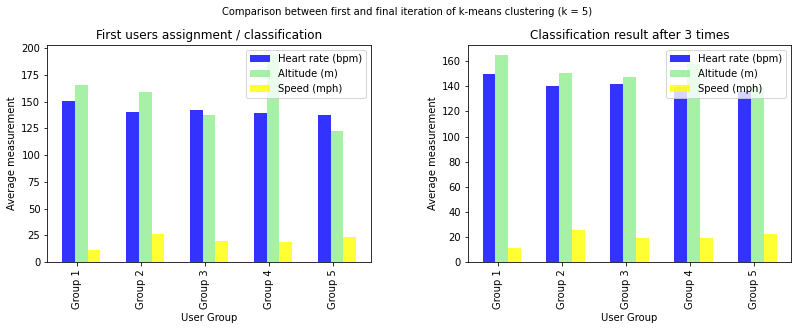

In [56]:
fig, axes = plt.subplots(1, 2, figsize=plt.figaspect(0.3))
subplot_adj = plt.subplots_adjust(wspace =0.3, hspace =0.5)

bar_width = 0.2
color = ['blue', 'lightgreen', 'yellow']
xShow = ['Group {}'.format(i+1) for i in range(5)]

avgAltitude = []
avgHeartrate = []
avgSpeed = []
avgAltitude1 = []
avgHeartrate1 = []
avgSpeed1 = []
for i in range(len(temprdds)):
    if i < 5:
        avgAltitude.append(
            np.mean(
                np.array(temprdds[i].rdd.map(lambda row: row['avgAltitudeSP']).collect())
            )
        )
        
        avgHeartrate.append(
            np.mean(np.array(temprdds[i].rdd.map(lambda row: row['avgHeartRateSP']).collect())
                   )
        )
        
        avgSpeed.append(
            np.mean(np.array(temprdds[i].rdd.map(lambda row: row['avgSpeedSP']).collect())
                   )
        )
    else:
        avgAltitude1.append(
            np.mean(np.array(temprdds[i].rdd.map(lambda row: row['avgAltitudeSP']).collect())
                   )
        )
        avgHeartrate1.append(
            np.mean(np.array(temprdds[i].rdd.map(lambda row: row['avgHeartRateSP']).collect())
                   )
        )
        avgSpeed1.append(
            np.mean(np.array(temprdds[i].rdd.map(lambda row: row['avgSpeedSP']).collect())
                   )
        )
ax = plt.subplot(1,2,1)
sca = plt.sca(ax)    
plot = plt.bar(
    x=np.arange(len(xShow)), height=avgHeartrate
    , label='Heart rate (bpm)', color=color[0], alpha=0.8, width=bar_width
)

plot = plt.bar(
    x=np.arange(len(xShow)) + 1 * bar_width, height=avgAltitude
    , label='Altitude (m)', color=color[1], alpha=0.8, width=bar_width
)
plot = plt.bar(
    x=np.arange(len(xShow)) + 2 * bar_width, height=avgSpeed
    , label='Speed (mph)', color=color[2], alpha=0.8, width=bar_width
)
xsticks = plt.xticks(np.arange(len(xShow)) + 0.7 * bar_width, xShow, rotation=90)
title = plt.title("First users assignment / classification")
legend = plt.legend()
xlabel = plt.xlabel("User Group")
ylabel = plt.ylabel("Average measurement")

ax=plt.subplot(1,2,2)
sca = plt.sca(ax) 
plot = plt.bar(
    x=np.arange(len(xShow)), height=avgHeartrate1
    , label='Heart rate (bpm)', color=color[0], alpha=0.8, width=bar_width
)
plot = plt.bar(
    x=np.arange(len(xShow)) + 1 * bar_width, height=avgAltitude1
    , label='Altitude (m)', color=color[1], alpha=0.8, width=bar_width
)
plot = plt.bar(
    x=np.arange(len(xShow)) + 2 * bar_width, height=avgSpeed1
    , label='Speed (mph)', color=color[2], alpha=0.8, width=bar_width
)
xsticks = plt.xticks(np.arange(len(xShow)) + 0.7 * bar_width, xShow, rotation=90)
title = plt.title("Classification result after {} times".format(times))
legend = plt.legend()
xlabel = plt.xlabel("User Group")
ylabel = plt.ylabel("Average measurement")
fig_title = fig.text(
    0.5, 1.01, 'Comparison between first and final iteration of k-means clustering (k = 5)'
    , ha='center', va='top', transform=fig.transFigure, fontsize='medium'
)